<a href="https://colab.research.google.com/github/kimimumemo/nanem/blob/main/Nanem_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

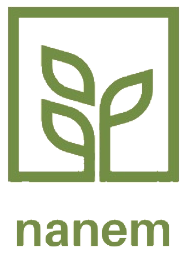

design logo by Myudi.

This notebook will walk you through the process of building a Machine Learning model for predicting what type of soil that you scan. 

We will classifying four species of soil by using **pre-trained TF2 SavedModel** from TensorFlow Hub for image feature extraction, which we trained on the much larger ImageNet dataset. 

Adding new classifier alongside can also be done in which we use the feature extractor ("fine-tuning").


# Step  1: Install packages

In [1]:
!pip install -U tensorflow-addons
!pip install -q keras
!pip install split-folders
# !pip install tensorflow-gpu

     |████████████████████████████████| 686kB 11.9MB/s 


In [2]:
!nvidia-smi

Wed Jun  9 12:22:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Step 2: Load the dependencies

In [3]:
import cv2 as cv2
import itertools
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow_hub as hub
import time
import tensorflow_addons as tfa
import uuid
import math

from glob import glob
from IPython.display import clear_output
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# Step 3: Select the TF2 SavedModel module to use

In [4]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1".format(handle_base)
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 with input size (224, 224)


In [5]:
IMG_SHAPE = (224,224,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [6]:
base_model.trainable = False

# Step 4: Import Dataset

Once you run the cell below, you will able to get our dataset in your Colaboratory environment.

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call('apt-get install subversion'.split())
    subprocess.call('svn export https://github.com/kimimumemo/nanem/trunk/nanem_dataset.zip'.split())
    
!unzip "/content/nanem_dataset.zip" -d "/content"

Archive:  /content/nanem_dataset.zip
  inflating: /content/nanem_dataset/Clay/Clay_7.png  
  inflating: /content/nanem_dataset/Humus/Humus_172.png  
  inflating: /content/nanem_dataset/Clay/Clay_149.png  
  inflating: /content/nanem_dataset/Clay/Clay_192.png  
  inflating: /content/nanem_dataset/Clay/Clay_293.png  
  inflating: /content/nanem_dataset/Clay/Clay_182.png  
  inflating: /content/nanem_dataset/Humus/Humus_132.png  
  inflating: /content/nanem_dataset/Humus/Humus_299.png  
  inflating: /content/nanem_dataset/Humus/Humus_99.png  
  inflating: /content/nanem_dataset/Clay/Clay_227.png  
  inflating: /content/nanem_dataset/Clay/Clay_143.png  
  inflating: /content/nanem_dataset/Humus/Humus_34.png  
  inflating: /content/nanem_dataset/Humus/Humus_135.png  
  inflating: /content/nanem_dataset/Humus/Humus_164.png  
  inflating: /content/nanem_dataset/Clay/Clay_259.png  
  inflating: /content/nanem_dataset/Clay/Clay_53.png  
  inflating: /content/nanem_dataset/Clay/Clay_51.png  
  i

In [8]:
BASE_DATASET_PATH = '/content/nanem_dataset'

# Step 5: See how many of each label we have

In [9]:
# To know how many picture in the datasets

num_files = 0

for folder in os.listdir(BASE_DATASET_PATH):
  files = os.listdir(os.path.join(BASE_DATASET_PATH, folder))
  # Calculate num files for image every folder
  print("{} folder has {} pictures".format(folder, len(files)))
  num_files += len(files)
print("\nThere are {} pictures in total".format(num_files))

Clay folder has 334 pictures
Alluvial folder has 354 pictures
Humus folder has 335 pictures
Latosol folder has 398 pictures

There are 1421 pictures in total


# Step 6: Split data to validation and training

In [10]:
BATCH_SIZE = 32

data_dir = BASE_DATASET_PATH

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
  train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 282 images belonging to 4 classes.
Found 1139 images belonging to 4 classes.


# Step 7: Build neural network

In [11]:
model = tf.keras.Sequential([
    # hub.KerasLayer(MODULE_HANDLE, dtype=tf.uint8),
    # hub.KerasLayer(MODULE_HANDLE, trainable=True),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()
# opt = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])
# callbacks from tensor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 250884    
Total params: 2,508,868
Trainable params: 250,884
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
 do_fine_tuning = False

# Step 8: Train neural network using training dataset

In [13]:
start = time.time()

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/100
35/35 [==============================] - 36s 158ms/step - loss: 1.2929 - accuracy: 0.3442 - val_loss: 1.2215 - val_accuracy: 0.3906
Epoch 2/100
35/35 [==============================] - 4s 120ms/step - loss: 1.1690 - accuracy: 0.4137 - val_loss: 0.9045 - val_accuracy: 0.5430
Epoch 3/100
35/35 [==============================] - 4s 119ms/step - loss: 0.9645 - accuracy: 0.5176 - val_loss: 0.9413 - val_accuracy: 0.5273
Epoch 4/100
35/35 [==============================] - 4s 119ms/step - loss: 0.9513 - accuracy: 0.5230 - val_loss: 1.0865 - val_accuracy: 0.4492
Epoch 5/100
35/35 [==============================] - 4s 119ms/step - loss: 0.8851 - accuracy: 0.5574 - val_loss: 0.9906 - val_accuracy: 0.5039
Epoch 6/100
35/35 [==============================] - 4s 120ms/step - loss: 0.8066 - accuracy: 0.5962 - val_loss: 0.8021 - val_accuracy: 0.5977
Epoch 7/100
35/35 [==============================] - 4s 121ms/step - loss: 0.7062 - accuracy: 0.6486 - val_loss: 0.7861 - val_accuracy: 0.609

# Step 9: Look at the performance of the model change whilst training

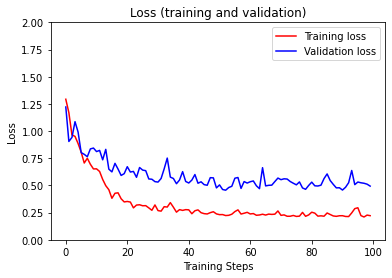

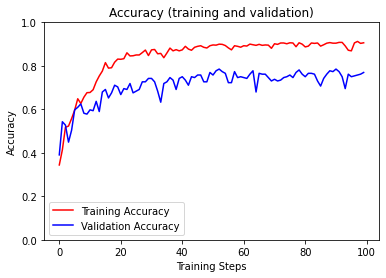

In [14]:
loss = hist['loss']
val_loss = hist['val_loss']
acc = hist["accuracy"]
val_acc = hist["val_accuracy"]
epochs = range(len(val_acc))

plt.figure()
plt.title("Loss (training and validation)")
plt.ylabel("Loss")
plt.xlabel("Training Steps")

plt.ylim([0,2])
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.legend()

plt.figure()
plt.title("Accuracy (training and validation)")
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")

plt.ylim([0,1])
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.legend()
plt.show()

# Step 10: Try out the model on an image from the validation data

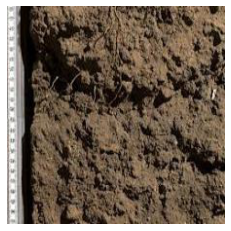

True label: Alluvial
Predicted label: Alluvial


In [15]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show() 

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# Step 11: Plot confusion matrix

In [16]:
#Determining y_true for confusion matrix
num_ex = len(valid_generator.filenames)
num_of_generator_calls = math.ceil(num_ex / (1.0 * BATCH_SIZE))

test_labels = []

for i in range(0, int(num_of_generator_calls)):
    test_labels.extend(np.array(valid_generator[i][1]))

y_true = []
for i in range(0, num_ex):
  a = 0
  for j in range(4):
    if test_labels[i][j] == 0:
      a += 1
      continue
    else:
      break
  y_true.append(a)

In [17]:
#Determining y_pred for confusion matrix
predict = model.predict(valid_generator,num_ex)
pred = np.argmax(predict, axis=1)
y_pred = []

for i in range(len(pred)):
    y_pred.append(pred[i])

In [18]:
#confusion matrix
conf =  confusion_matrix(valid_generator.classes, y_pred)
# norm_conf = conf/conf.astype(np.float).sum(axis=1)

In [19]:
al=0
cl=0
red=0
bl=0
for i in range(4):
  for j in range(4):
    if i == 0:
      al += conf[i][j]
    elif i == 1:
      cl += conf[i][j]
    elif i == 2:
      red += conf[i][j]
    elif i == 3:
      bl += conf[i][j]

In [20]:
# initialize
conf_percent=np.zeros((4,4), np.float32)

for i in range(4):
  for j in range(4):
    if i == 0:
      conf_percent[i][j] = conf[i][j]/al
    elif i == 1:
      conf_percent[i][j] = conf[i][j]/cl
    elif i == 2:
      conf_percent[i][j] = conf[i][j]/red
    elif i == 3:
      conf_percent[i][j] = conf[i][j]/bl

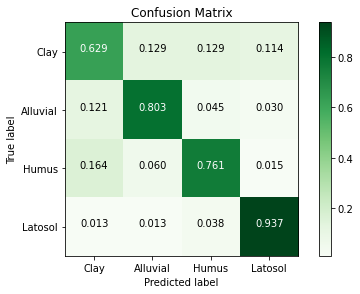

In [21]:
classes = os.listdir(BASE_DATASET_PATH)
# classes = ['Alluvial', 'Clay', 'Latosol', 'Humus']
# plot confusion matrix
plt.imshow(conf_percent, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = '0.3f'
thresh = conf_percent.max() / 2.
for i, j in itertools.product(range(conf_percent.shape[0]), range(conf_percent.shape[1])):
    plt.text(j, i, format(conf_percent[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_percent[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('plot_confusion_matrix.png')

#Step 12: TF Lite

In [ ]:
saved_model_path = '/content/drive/Shareddrives/Nanem/model/model_download_baru_3/checkpoint'
# tf.saved_model.save(model, saved_model_path)
model.save(saved_model_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Nanem/model/model_download_baru_3/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Nanem/model/model_download_baru_3/checkpoint/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join('/content/drive/Shareddrives/Nanem/model/model_download_baru_3/tflite', 'model_4.tflite'), 'wb') as f:
  f.write(tflite_model)

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open('/content/sample_data/model.tflite', "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 9873704 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 45  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 45 of 45 examples (100%).
TF Lite model is accurate on 43 of 45 examples (95.5556%).


# Step 13: Push this Notebook to Github

In [23]:
!git clone https://github.com/kimimumemo/nanem.git

fatal: destination path 'nanem' already exists and is not an empty directory.
